# Random Forest
Vamos a ver primero el porque el Random Forest funciona mejor que un Decision Tree.

Generador Números Aleatorios, ganas un 60% de las veces:
\begin{itemize}
\item Juego 1: 100 veces, apostando 1E cada vez.
\item Juego 2: 10 veces, apostando 10E cada vez.
\item Juego 3: 1 vez, apostando 100E cada vez.
\end{itemize}

¿Cual jugarías?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Vamos ahora ha hacer una simulación de Montecarlo de como funciona teoricamente el Random Forest.  Del primer juego:

In [ ]:
simulations = 10000  # numero de simulaciones Monte Carlo 
games = 100          # number de veces que jugamos
threshold = 40       # Porcentaje de victoria/perdida
bet = 1              # apuesta

sim_results_1 = []
for sim in range(simulations):
    result = []
    for g in range(games):
        number = int(np.random.uniform()*100)  # get a random number to see who wins
        if number >= threshold:
            result.append(bet)
        else:
            result.append(-bet)
    sim_results_1.append(sum(result))          # sim_results_1 stores results for Game 1
print('Game 1 Mean: ', round(np.mean(sim_results_1), 2))
print('Game 1 Prob Positive: ', round(sum([1 for i in sim_results_1 if i>0])/simulations, 2))
print('\n')

Vamos ahora ha hacer una simulación de Montecarlo de como funciona teoricamente el Random Forest.  Del segundo juego:

In [ ]:
simulations = 10000
games = 10
threshold = 40
bet = 10

sim_results_2 = []
for sim in range(simulations):
    result = []
    for g in range(games):
        number = int(np.random.uniform()*100)
        if number >= threshold:
            result.append(bet)
        else:
            result.append(-bet)
    sim_results_2.append(sum(result))
print('Game 2 Mean: ', round(np.mean(sim_results_2), 2))
print('Game 2 Prob Positive: ', round(sum([1 for i in sim_results_2 if i>0])/simulations, 2))
print('\n')
    

Vamos ahora ha hacer una simulación de Montecarlo de como funciona teoricamente el Random Forest.  Del segundo juego:

In [ ]:
simulations = 10000
games = 1
threshold = 40
bet = 100

sim_results_3 = []
for sim in range(simulations):
    result = []
    for g in range(games):
        number = int(np.random.uniform()*100)
        if number >= threshold:
            result.append(bet)
        else:
            result.append(-bet)
    sim_results_3.append(sum(result))
print('Game 3 Mean: ', round(np.mean(sim_results_3), 2))
print('Game 3 Prob Positive: ', round(sum([1 for i in sim_results_3 if i>0])/simulations, 2))

Vamos a ver unas gráficas:

In [ ]:
# Histograma
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(sim_results_1, kde=False, bins=60, label='Jugado 100 veces')
sns.distplot(sim_results_2, kde=False, bins=60, label='Jugado 10 veces')
sns.distplot(sim_results_3, kde=False, bins=60, label='Jugado 1 vez', color='pink')

ax.set_xlabel('Dinero que has ganado', fontsize=16)
ax.set_ylabel('Frecuencia',fontsize=16)
plt.legend()
plt.tight_layout()

plt.savefig(fname='game_hist', dpi=150)
plt.show()

## Ejemplo de Random Forest
Para este ejemplo vamos a usar el dataset de kaggle del Titanic, https://www.kaggle.com/c/titanic, donde vamos a descargarnos los datos de entreno y testeo desde: https://www.kaggle.com/c/titanic/data.

El 15 de abril de 1912, durante su viaje inaugural, el ampliamente considerado "insumergible" RMS Titanic se hundió después de chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, lo que resultó en la muerte de 1502 de 2224 pasajeros y tripulantes.

Si bien hubo algún elemento de suerte involucrado en la supervivencia, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

"¿qué tipo de personas tenían más probabilidades de sobrevivir?" utilizando datos de pasajeros (es decir, nombre, edad, sexo, clase socioeconómica, etc.).

In [1]:
import os              # Package to use directory command to list files
import numpy as np     # linear algebra
import pandas as pd    # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # Used for plotting the graph
import matplotlib.pyplot as plt
import re

from scipy import stats # for Statistics
from statistics import mean
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline


Vamos primero a cargar los datos:

In [2]:
data = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

# To check the data since it can have issues
# Do not train with this!
df = data.append(test, sort = False)
print(df.shape)
df.head(10)


(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Vemos que el dataset no esta limpio, hay que arreglarlo:

In [18]:
totalt = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
Survived,418,0.319328
AgeFill,263,0.200917
Age,263,0.200917
AgeIsNull,0,0.000000
Embarked,0,0.000000
Cabin,0,0.000000


Miremos que entrada le falta el precio del tiquet:

In [4]:
df.loc[df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [5]:
df.loc[(df['Age'] >= 60) & (df['Pclass'] ==3) & (df['Sex'] == 'male') & (df['Embarked'] =='S')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
326,327,0.0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
851,852,0.0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [6]:
df.loc[df['Fare'].isnull(), 'Fare'] = 7

En este caso con una media ha sido facil encontrar una solucion a este dato. Sigamos ahora, empecemos mirando la distribucion de los datos:

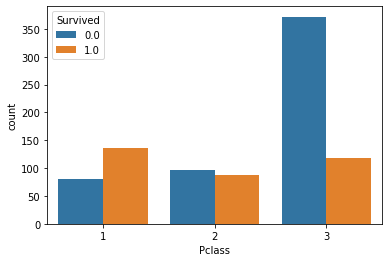

In [7]:
train1 = df[0:891].copy()
plt.figure()
ax = sns.countplot(x='Pclass',hue="Survived", data=train1)
plt.show()

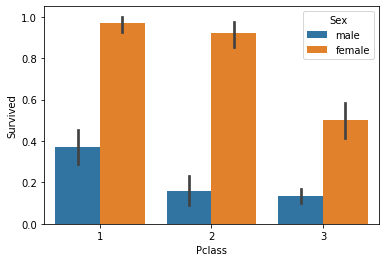

In [8]:
plt.figure()
ax = sns.barplot(x="Pclass", y="Survived",hue='Sex', data=train1)
plt.show()

Vamos ahora a mirar que pasa con los datos de cabina. Para todos aquellos que no sepamos que cabina estubo, pondremos 0, para el resto, usamos una herramienta de scikit para renombrar las cabinas a numeros.

In [9]:
df.Cabin = df.Cabin.fillna('0')   

le = preprocessing.LabelEncoder()
le.fit(df['Cabin'].astype(str))  
df['Cabin'] = le.transform(df['Cabin'].astype(str))

df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,107,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,71,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,0,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,164,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,0,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C


Vamos ahora a ver como hacemos para rellenar la edad. Podriamos usar la media, la mediana...

In [10]:
data.loc[data['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [44]:
median_ages = np.zeros((2,3))

for i in range(0,2):
    for j in range(0,3):
        median_ages[i,j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()

df['AgeFill'] = df['Age']

for i in range(0,2):
    for j in range(0,3):
        df.loc[(df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), 'AgeFill'] = median_ages[i,j]

# Nos guardamos que años eran null por si acaso
df['AgeIsNull'] = pd.isnull(df.Age).astype(int)


**Ejercicio:** Se os ocurre alguna otra manera de hacer esto?




Sigamos ahora mirando el resto de variables.


In [47]:
df.loc[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,AgeIsNull


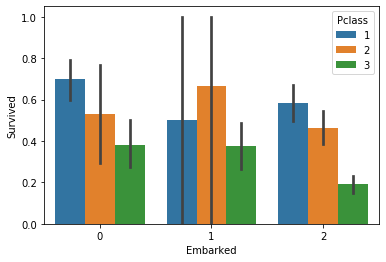

In [48]:
plt.figure()
ax = sns.barplot(x="Embarked", y="Survived",hue='Pclass', data=df)
plt.show()

Viendo esto podemos:

In [49]:
def FillEmbk(data):
    var = 'Embarked'
    data.loc[(data.Embarked.isnull()),'Embarked']= 'C'

FillEmbk(df)
df.loc[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,AgeIsNull


Como antes, vamos a renombrar las features de embarcados y el sexo en labels:

In [50]:
def LablFunc(data):
    lst = {'Embarked','Sex'}
    for i in lst:
        le.fit(data[i].astype(str))
        data[i] = le.transform(data[i].astype(str))
        
LablFunc(df)
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeFill', 'AgeIsNull'],
      dtype='object')


### Preprocesado del dato
Vamos a preprocesar los datos escalando las entradas y vamos preparando el dataset


In [51]:
from sklearn.preprocessing import StandardScaler
target = data['Survived'].values
# select_features = ['Pclass', 'Age','SibSp', 'Parch', 'Fare', 'Embarked','Cabin','Sex']
select_features = ['Pclass', 'AgeFill','SibSp', 'Parch', 'Fare', 'Embarked','Cabin','Sex']


scaler = StandardScaler()
dfScaled = scaler.fit_transform(df[select_features])

train = dfScaled[0:891].copy()
test = dfScaled[891:].copy()

Ahora ya estamos preparados para entrenar el modelo con scikit. Vamos a mirar por eso, la importancia de los datos usando SelectKbest que ya conociais del modulo anterior:

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

Vamos ahora a aplicar el Random Forest:

In [57]:
from sklearn.ensemble import RandomForestClassifier  # importing model to use for our prediction
from sklearn.metrics import classification_report

RFC = RandomForestClassifier(max_depth = 5, min_samples_split = 4, n_estimators = 500,random_state = 20, n_jobs = -1)
RFC.fit(x_train, y_train) 
train_prediction = RFC.predict(x_train)
print("La accuracy es de {}.".format(accuracy_score(y_train,train_prediction)))
print(classification_report(y_train, train_prediction))



La accuracy es de 0.8764044943820225.
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       444
           1       0.92      0.74      0.82       268

    accuracy                           0.88       712
   macro avg       0.89      0.85      0.86       712
weighted avg       0.88      0.88      0.87       712



Vamos a predecir el test:

# Si quereis enviarlo a Kaggle:
Tenes que ejecutar esto

In [ ]:
# RFC.fit(train, target)   
# train_prediction = RFC.predict(train)
# print("La accuracy es de {}.".format(accuracy_score(target,train_prediction)))
test_prediction = RFC.predict(test)   #using Random Forest Classifier
print('Predicted result: ', test_prediction)
sampl = pd.read_csv('gender_submission.csv')
sampl['Survived'] = pd.DataFrame(test_prediction)
sampl.to_csv('submission.csv', index=False)